# Further line analysis from saved moment images

The previous notebook has grown too long, so I am starting a new one.  What I plan to do here is: 

1. [X] [Cl III] density ratio. *Conclusion:* [Cl III] is useless
2. [X] [S II] density - this is the best
3. [ ] He II analysis – ionizing luminosity and density
    *This has a mistake at the moment, which I need to track down*
4. [ ] [Ar IV] and [Ar III] ionization balance
2. [ ] Maybe tetrablok binning and make figure
3. [X] Profile cuts across the bow shock
4. [ ] Analysis of average line velocities 


In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import cmasher as cmr
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

In [16]:
def trim_edges(im, m):
    """Trim m pixels of each edge of image in place by setting mask"""
    im.mask[:m, :] = True
    im.mask[-m:, :] = True
    im.mask[:, :m] = True
    im.mask[:, -m:] = True
    return None

## [S II] density

In [234]:
im6716 = Image("../data/ngc346-sii-6716-bin01-sum.fits")
im6731 = Image("../data/ngc346-sii-6731-bin01-sum.fits")
imha = Image("../data/ngc346-hi-6563-bin01-sum.fits")
imcont = Image("../data/ngc346-cont-6312-mean.fits")

In [256]:
s2 = pn.Atom("S", 2)
e6716 = s2.getEmissivity(tem=13000, den=[3, 10, 30, 100, 300, 1000], wave=6716)
e6731 = s2.getEmissivity(tem=13000, den=[3, 10, 30, 100, 300, 1000], wave=6731)
Rgrid = e6716 / e6731
Rgrid

array([1.43878982, 1.43185268, 1.4125499 , 1.35049829, 1.20992   ,
       0.93887822])

In [236]:
m = imcont.data > 5e3
im6716.mask = im6716.mask | m
im6731.mask = im6731.mask | m
trim_edges(im6716, 10)
trim_edges(im6731, 10)
trim_edges(imcont, 10)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


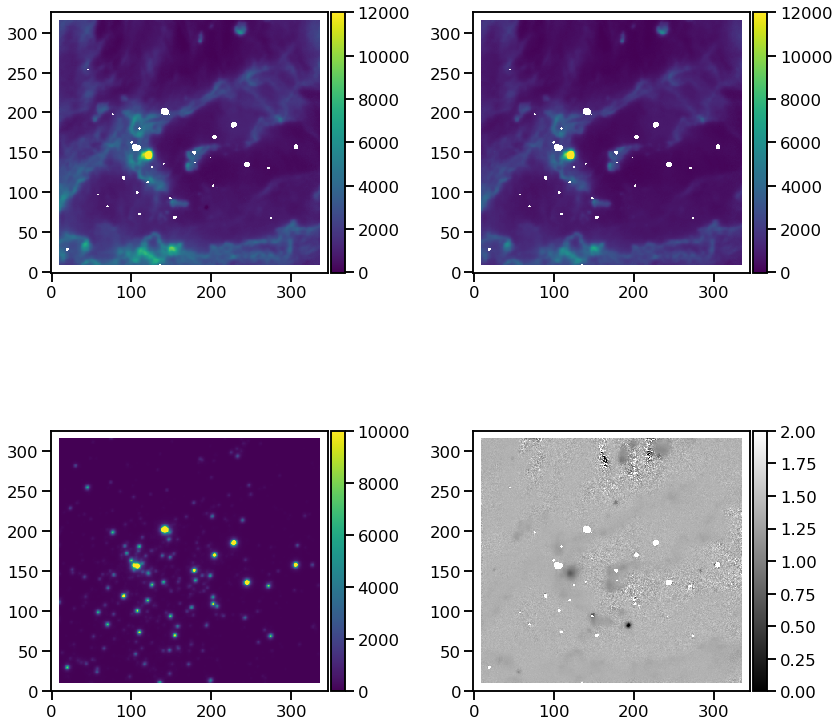

In [237]:
n = 1
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im6716.rebin(n).plot(vmin=-10, vmax=12000, ax=axes[0, 0], colorbar="v")
im6731.rebin(n).plot(vmin=-10, vmax=12000, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(
    im6716.rebin(n)
    / im6731.rebin(n)
).plot(
    ax=axes[1, 1],
    vmin=0.0, 
    vmax=2.0, 
    cmap="gray", 
    colorbar="v",
)
fig.tight_layout();

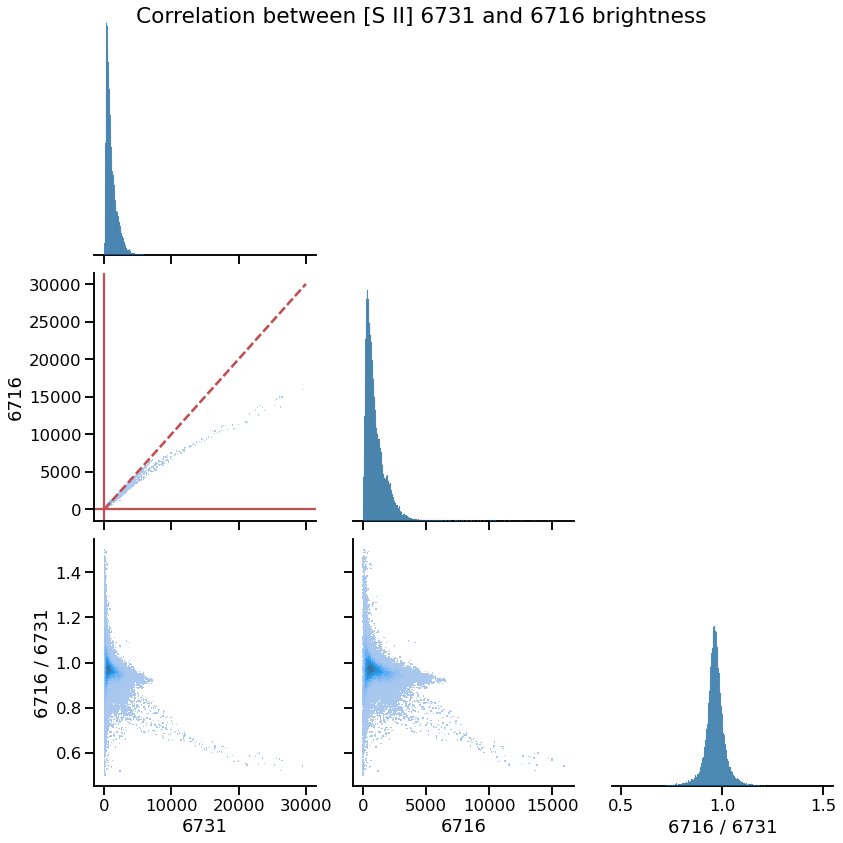

In [245]:
n = 1

imx = im6731.rebin(n)
imy = (im6716 / 1.44).rebin(n)

imin, imax = -10, 30000
m = (imx.data < imax) & (imy.data < imax)
m = m & (imx.data > imin) & (imy.data > imin)
m = m & (imy.data / imx.data > 0.5) & (imy.data / imx.data  < 1.5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6731": imx.data[m],
        "6716": imy.data[m],
        "6716 / 6731": imy.data[m] / imx.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.fig.suptitle("Correlation between [S II] 6731 and 6716 brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


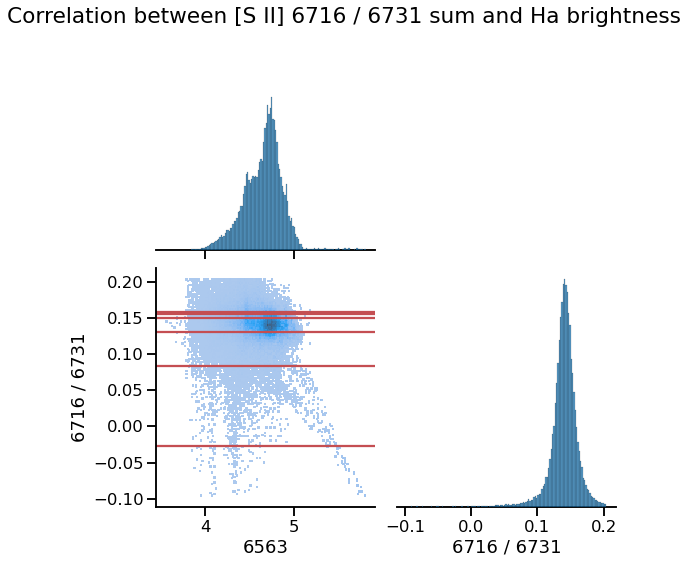

In [272]:
n = 1
imx = imha.rebin(n)
imy = im6716.rebin(n) / im6731.rebin(n)

m = (imy.data > 0.8) & (imy.data < 1.6)
m = m & (imx.data < 1.5e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
)
for R in Rgrid:
    g.axes[1, 0].axhline(np.log10(R), color="r")
g.fig.suptitle("Correlation between [S II] 6716 / 6731 sum and Ha brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


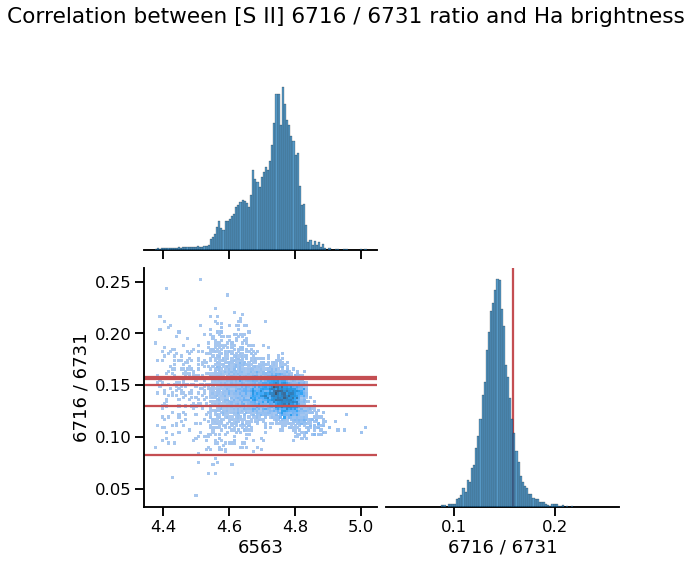

In [273]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 1

imx = imha[yslice, xslice].rebin(n)
imy = im6716[yslice, xslice].rebin(n) / im6731[yslice, xslice].rebin(n)

m = (imy.data > 1.1) & (imy.data < 2)
m = m & (imx.data < 1e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
)
g.axes[1, 1].axvline(np.log10(Rgrid[0]), color="r")
for R in Rgrid[:-1]:
    g.axes[1, 0].axhline(np.log10(R), color="r")

g.fig.suptitle("Correlation between [S II] 6716 / 6731 ratio and Ha brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


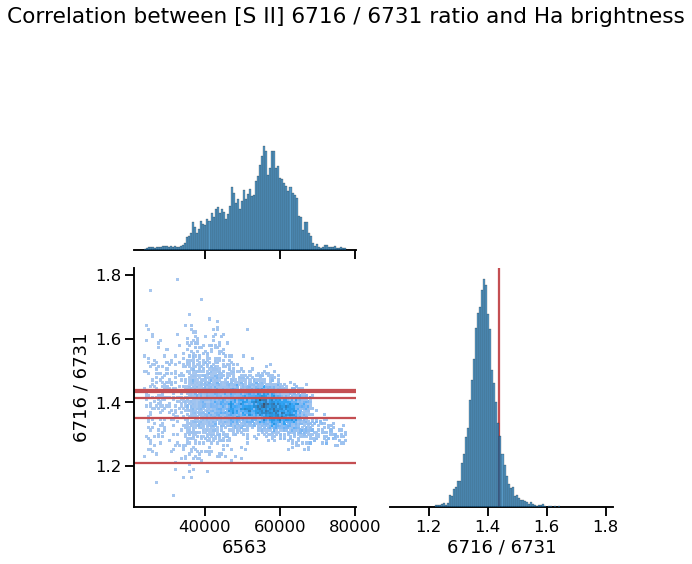

In [275]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 1

imx = imha[yslice, xslice].rebin(n)
imy = im6716[yslice, xslice].rebin(n) / im6731[yslice, xslice].rebin(n)

m = (imy.data > 1.1) & (imy.data < 2)
m = m & (imx.data < 80000)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": imx.data[m],
        "6716 / 6731": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
)
g.axes[1, 1].axvline(Rgrid[0], color="r")
for R in Rgrid[:-1]:
    g.axes[1, 0].axhline(R, color="r")

g.fig.suptitle("Correlation between [S II] 6716 / 6731 ratio and Ha brightness");

So, in the bow shock region, we see ratios as low as 1.3 in the brightest parts, but these are globule surfaces.  The bulk of the emission has around 1.4

In [277]:
s2.getTemDen([1.4, 1.3, 0.8], tem=12000, wave1=6716, wave2=6731)

array([  45.20353656,  162.86088958, 1705.88138223])

So the density is about 50 +/- 30 pcc in the diffuse gas.  We get ten times higher density in the case of Source E, which has a ratio as low as 0.8

### Make a map of [S II] density

In [305]:
r_s2_grid = np.linspace(0.5, 1.44, 1001)
n_s2_grid = s2.getTemDen(r_s2_grid, tem=12000.0, wave1=6716, wave2=6731)

In [306]:
n_s2_grid

array([1.40424705e+04, 1.38947675e+04, 1.37382380e+04, ...,
       6.72335754e+00, 6.72335754e+00, 6.72335754e+00])

In [329]:
iew6716 = imcont / (1.25 * im6716)

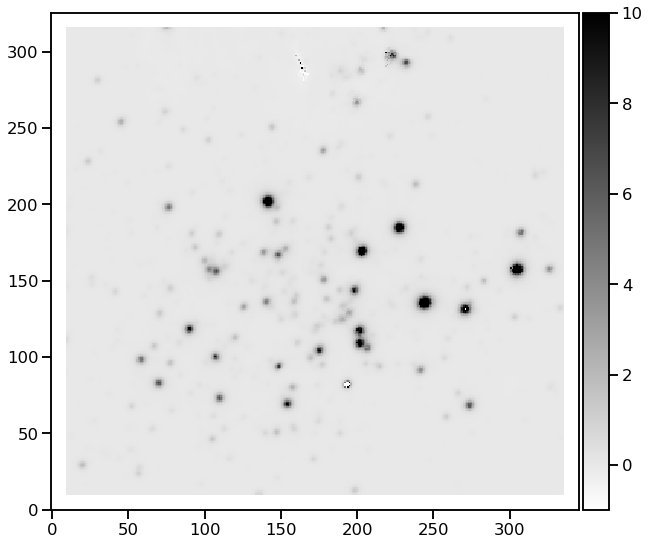

In [360]:
fig, ax = plt.subplots(figsize=(10, 10))
iew6716.plot(colorbar="v", cmap="gray_r", scale="linear", vmin=-1.0, vmax=10.); 

In [373]:
fixmask = im6716.mask | (iew6716.data > 10.0) | (iew6716.data < -0.2)
fixmask[90:97, 147:152] = True
fixmask[79:86, 191:197] = True


im_n_sii = im6716.clone(data_init=np.empty)
im_n_sii.mask = fixmask
trim_edges(im_n_sii, 10)
im_n_sii.data[~fixmask] = np.interp(
    im6716.data[~fixmask] / im6731.data[~fixmask], 
    r_s2_grid, n_s2_grid,
    left=np.nan, right=np.nan,
)
im_n_sii.mask = im_n_sii.mask | ~np.isfinite(im_n_sii.data)

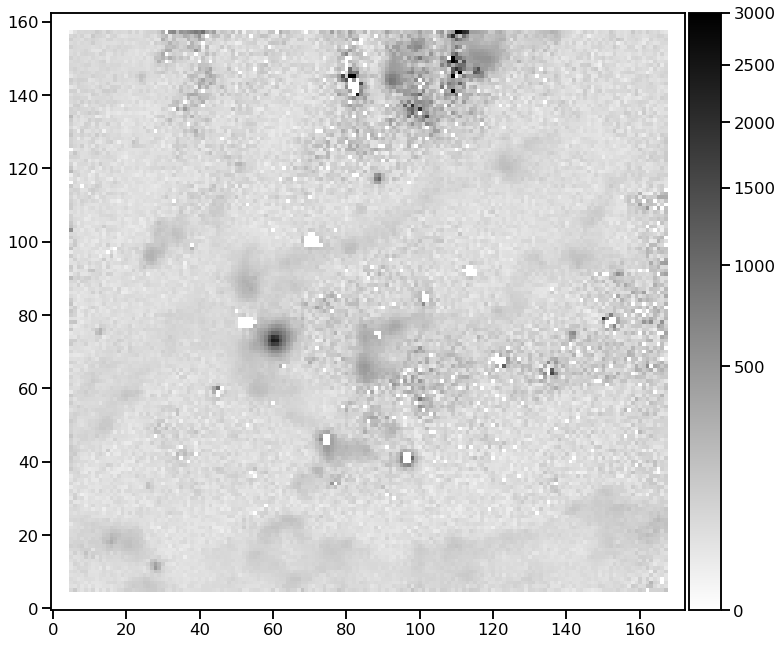

In [375]:
fig, ax = plt.subplots(figsize=(12, 12))
im_n_sii.rebin(2).plot(colorbar="v", cmap="gray_r", scale="sqrt", vmin=0.0, vmax=3000.); 

This seems to be good enough in some of the diffuse regions. although it is way to noisy in the faint parts. 

### Compare [S II] density with [S III] temperature

In [376]:
im_n_sii.write("../data/ngc346-N-sii.fits", savemask="nan")

In [468]:
im_T_siii = Image("../data/ngc346-T-siii.fits")

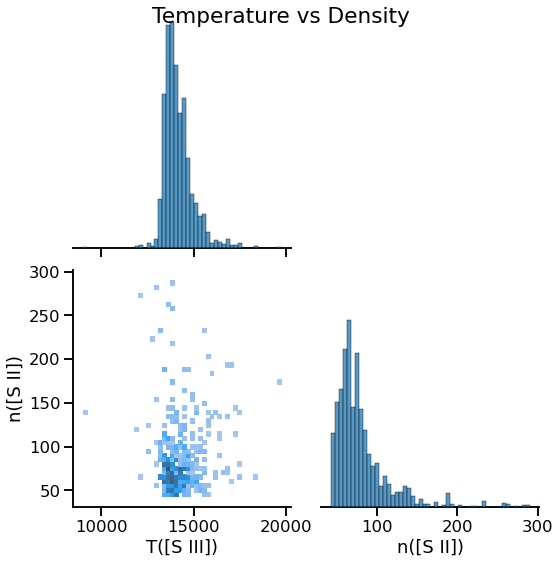

In [472]:
n = 16
imx = im_T_siii.rebin(n)
imy = im_n_sii.rebin(n) 
imz = imhb.rebin(n)

m = ~imx.mask & ~imy.mask
m = m & (imx.data > 5000) & (imx.data < 20000)
m = m & (imy.data > 0) & (imy.data < 300)
df = pd.DataFrame(
    {
        "T([S III])": imx.data[m],
        "n([S II])": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imz.data[m],
        bins=50,
    ),
    diag_kws=dict(
        weights=imz.data[m],
        bins=50,
    ),
)
g.fig.suptitle("Temperature vs Density");

## He II emission measure

In [282]:
he2 = pn.RecAtom("He", 2)
he1 = pn.RecAtom("He", 1)
h1 = pn.RecAtom("H", 1)


In [296]:
e4686 = he2.getEmissivity(tem=18000, den=1, wave=4686)
e4686cold = he2.getEmissivity(tem=12000, den=1, wave=4686)
e4861 = h1.getEmissivity(tem=12000, den=1, wave=4861)
e5875 = he1.getEmissivity(tem=12000, den=1, wave=5876)
e4686, e4686cold, e4861, e5875

(array(8.172e-25),
 array(1.25516667e-24),
 array(1.05083333e-25),
 array(1.37667048e-25))

From the other notebook, we measure 5875 / 4861 = 0.108 +/- 0.001

Whereas the ratio of emissivities is 

In [290]:
e5875 / e4861

1.310075001033523

This implies a He abundance of 

In [295]:
np.array([0.107, 0.108, 0.109]) / (e5875 / e4861)

array([0.08167471, 0.08243803, 0.08320134])

From Table 5 of Valerdi+ (2019), they have a He+ abundance of 10.915 or 10.917, with error of +/- 0.004 , so:

In [294]:
10**(np.array([10.915, 10.917]) - 12.0)

array([0.08222426, 0.08260379])

They find a small He++ abundance of 

In [300]:
f"He++/H+ = {10**(8.30 - 12.0):.3e}; He++/He+ = {10**(8.30 - 10.915):.3e}"

'He++/H+ = 1.995e-04; He++/He+ = 2.427e-03; '

In the bow shock I measure 4686 / 4861 = 0.015 or so, which would be 1.5 on a scale of Hβ = 100.  Mabel's Table 2 gives 0.24, which is 6 times less. This is consistent with the general value we find away from the bow's inner edge. 

So, I can work out my own He++/H+ abundance: 

In [304]:
y_heiii_hii = 0.015 / (e4686 / e4861)
y_heiii_heii = y_heiii_hii / 0.08167471
f"Bow shock He++/H+ = {y_heiii_hii:.4f}; He++/He+ = {y_heiii_heii:.4f}"

'Bow shock He++/H+ = 0.0019; He++/He+ = 0.0236'

In other words, the He++ emission measure, $\int n(\mathrm{He^{++}})\, n_\mathrm{e}\, dz$, is ony 2.5% of the total $\int n(\mathrm{He^{+}})\, n_\mathrm{e}\, dz$.

*This is totally consistent, with the observed small change in 5875/4861, which is also about 2%* 

**TODO**

- [ ] By assuming a path length, we can derive a density
- [ ] We can do the same with [Ar IV] and [Ar III] 
- [ ] Ask Mabel to look at her slit A to see if she sees the He II and [Ar IV] signatures of the bow shock.  Also, maybe measure [O III] temperature to see if it goes up

### Conversion to a density

We want the surface brightness of He++ in physical units. 

MUSE flux units are $10^{-20}\ \mathrm{erg\ s^{-1}\ cm^{-2}\ Å^{-1}\ pix^{-1}}$ in the cube, but we have summed over wavelength pixels, which are 1.4 Å.  The spatial pixels are 0.2 arcsec. 

In [377]:
import astropy.units as u

In [378]:
muse_bright_unit = 1e-20 * 1.4 * u.erg / u.s / u.cm**2 / (0.2 * u.arcsec)**2

In [382]:
muse_bright_unit = muse_bright_unit.to(u.erg / u.s / u.cm**2 / u.sr)
muse_bright_unit

<Quantity 1.48908096e-08 erg / (cm2 s sr)>

In [412]:
im4686 = Image("../data/ngc346-heii-4686-correct.fits")
im5875 = Image("../data/ngc346-hei-5875-correct.fits")
imhb = Image("../data/ngc346-hi-4861-correct.fits")
imariv = Image("../data/ngc346-ariv-4711-plus-4740-correct.fits")
imariii = Image("../data/ngc346-ariii-7136-correct.fits")
imoiii = Image("../data/ngc346-oiii-5007-bin01-sum.fits")

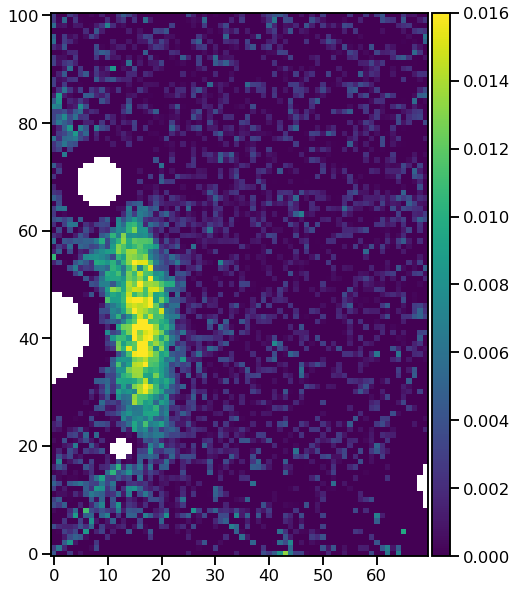

In [397]:
fig, ax = plt.subplots(figsize=(10, 10))
(im4686 / imhb)[yslice, xslice].plot(vmin=0.0, vmax=0.016, colorbar="v")

In [422]:
yslice

slice(144, 245, None)

In [568]:
xxslice = slice(None, None)
#yyslice = slice(164, 204) # original
#yyslice = slice(160, 210) # broader
#yyslice = slice(170, 200) # narrower
yyslice = slice(180, 200) # top half ultra narrow


def make_profile(im):
    #return np.make(im[yyslice, xxslice].data, axis=0)
    return np.mean(im[yyslice, xxslice].data, axis=0)

heii_profile = make_profile(im4686)
hei_profile = make_profile(im5875)
hb_profile = make_profile(imhb)
ariv_profile = make_profile(imariv)
ariii_profile = make_profile(imariii)
oiii_profile = make_profile(imoiii)

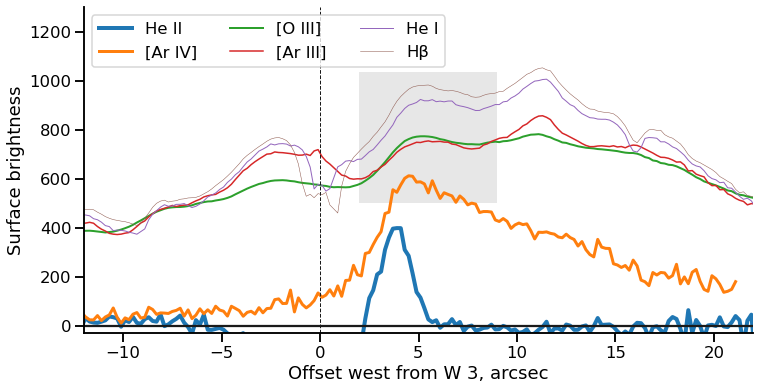

In [570]:
fig, ax = plt.subplots(figsize=(12, 6))
ix0 = 227.5
nx = len(heii_profile)
pos = (np.arange(nx) - ix0) * 0.2

ax.plot(pos, heii_profile, label="He II", lw=4)
ax.plot(pos, 1.00 * ariv_profile, label="[Ar IV]", lw=3)
ax.plot(pos, 3 * 0.0019 * oiii_profile, label="[O III]", lw=2.0)
ax.plot(pos, 3 * 0.13 * ariii_profile, label="[Ar III]", lw=1.5)
ax.plot(pos, 3 * 0.100 * hei_profile, label="He I", lw=1.0)
ax.plot(pos, 3 * 0.011 * hb_profile, label="Hβ", lw=0.5)


ax.axhline(0, color="k")

ax.axvline(0, color="k", lw=1, ls="dashed")
ax.axvspan(2.0, 9.0, 0.4, 0.8, color="k", alpha=0.1, linewidth=0, zorder=-100)
ax.legend(ncol=3,loc="upper left")

ax.set(
    xlabel="Offset west from W 3, arcsec",
    ylabel="Surface brightness",
    xlim=[-12, 22],
    ylim=[-30, 1300],
)
sns.despine()
fig.savefig("../figs/ngc346-bow-shock-brightness-cuts.pdf");

From the profile graph above, the peak He II brightness is about 400 MUSE brightness units

In [452]:
peak_heii = muse_bright_unit * 400

From the image, the chord length through the bow is about 60 pixels.  We can assume that the line-of-sight depth is similar:

In [455]:
depth_heii = 60 * 0.2 * 61700 * u.au
depth_heii.to(u.pc)

<Quantity 3.58956049 pc>

Surface brightness assuming optically thin emission with isotropic line emissivity, $e(\lambda)$, is given by 
$$
I(\lambda) = \int \frac{e(\lambda)\, n_e\, n_i}{4 \pi} \, dz 
$$
where $e(\lambda)$ is in the units given by pyneb: `u.erg * u.cm**3 / u.s` and $n_e$, $n_i$ are the electron and ion densities. 

Assume neutral fractions of He and H are negligible and hydrogen number density is $n$.  If the He abundance is $y = n(\mathrm{He}) / n(\mathrm{H})$ and the He++ ion fraction is $x_{++}$, then we have:
$$
n(\mathrm{He^{++}}) = y\, x_{++}\, n \quad \text{and} \quad n_e = [1 + y\, (1 + x_{++})]\, n
$$
implying that 
$$
n(\mathrm{He^{++}}) \, n_e = n_e^2 \, \frac{y\, x_{++}}{1 + y\, (1 + x_{++})}
\approx n_e^2 \, \frac{y}{1 + 2 y}
$$

So, with homogeneous conditions, we have
$$
I(4686) = \frac{e(4686)}{4\pi}\, \frac{y}{1 + 2 y} \, n_e^2 \, \delta z
$$
which can be solved for density to yield
$$
n_e = \left[
\frac{4\pi\, I(4686)}{\delta z\, e(4686)} \, \frac{1 + 2 y}{y} 
\right]^{1/2}
$$

We can take the helium abundance from above and get ...

In [467]:
pn_e_units = u.erg * u.cm**3 / u.s
yHe = 0.0824
ne = np.sqrt(
    4 * np.pi * u.sr * peak_heii / (depth_heii.cgs * e4686 * pn_e_units)
    * (1 + 2 * yHe) / yHe
)
ne

<Quantity 10.81175182 1 / cm3>

**So electron density of 11 pcc!**

Note, however that this assumes that the helium is 100% doubly ionized in the 4686 emitting region. If it is only partially ionized, then this is alower limit (density would scale approximately as $x_{++}^{-1/2}$). 

#### Find the He II flux and the He++ ionizing luminosity



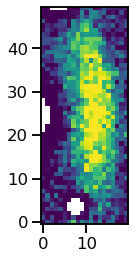

In [487]:
im4686[160:210, 235:255].plot(vmin=0, vmax=400)

In [489]:
muse_flux_unit = 1e-20 * 1.4 * u.erg / u.s / u.cm**2 

In [490]:
cutout = im4686[160:210, 235:255]
m = (cutout.data > 0.0) & ~cutout.mask
F_heii = muse_flux_unit * np.sum(cutout.data[m])
F_heii

<Quantity 2.03703113e-15 erg / (cm2 s)>

In [491]:
D_lmc = 61700 * u.pc

In [492]:
L_heii = 4 * np.pi * D_lmc.cgs**2 * F_heii
L_heii

<Quantity 9.27852514e+32 erg / s>

In [494]:
L_heii.to(u.solLum)

<Quantity 0.24238571 solLum>

Effective recomb rate:

In [496]:
import astropy.constants as constants

In [501]:
hnu4686 = (constants.h * constants.c / (4686 * u.Angstrom)).cgs
hnu4686

<Quantity 4.23910768e-12 erg>

In [502]:
alpha_eff_4686 = e4686 * pn_e_units / hnu4686
alpha_eff_4686

<Quantity 1.9277642e-13 cm3 / s>

In [509]:
pn.atomicData.getAllAvailableFiles("He2")

['* 3he_ii_atom_cloudy.dat',
 '* 3he_ii_coll_cloudy.dat',
 '* he_ii_rec_SH95.hdf5',
 'he_ii_rec_P91.func',
 'he_ii_rec_SH95-caseA.fits',
 'he_ii_rec_SH95-caseA.hdf5',
 'he_ii_rec_SH95.fits',
 'he_ii_trc_SH95-caseA.dat',
 'he_ii_trc_SH95-caseB.dat']

It only works as follows:

In [523]:
pn.atomicData.setDataFile('he_ii_trc_SH95-caseB.dat')
alphaB_He_plus = pn.RecAtom("He", 2).getTotRecombination(tem=10000, den=100)
alphaB_He_plus *= u.cm**3 / u.s
alphaB_He_plus

<Quantity 1.533e-12 cm3 / s>

Solid angle: assume a +/- 75 degree end cap.  

In [526]:
Omega_over_4pi = (1 - np.cos(75*u.deg)) / 2
Omega_over_4pi

<Quantity 0.37059048>

$$
Q \frac{\Omega}{4\pi} = \int_{\mathcal{V}} n_e \, n_i \, \alpha_B\, d\mathcal{V}
$$
and
$$
L(4686) = \int_{\mathcal{V}} n_e \, n_i \, e(4686)\, d\mathcal{V}
$$
so that 
$$
Q = \frac{\alpha_B \, L(4686)} {e(4686)\, (\Omega/4\pi)}
$$

In [527]:
Q2 = alphaB_He_plus * L_heii / (e4686 * pn_e_units) / Omega_over_4pi
Q2

<Quantity 4.69676131e+45 1 / s>

## Ar ionization balance

We will calculate the conditions at the very peak of the [Ar IV] emission. 

We need a very careful slection of the background (BG) and bow shock (BS) samples, since we want to make sure we are in the little triangle window where the intermediate ionization lines are not too contaminated by globule i-fronts and unrelated filaments.

In [598]:
i0, j0, w, h = 234, 200, 12, 8
bgbox = regions.BoundingBox(
    iymin=j0 - h//2, iymax=j0 + h//2, 
    ixmin=i0 - w//2, ixmax=i0 + w//2,
)
i0, j0, w, h = 250, 193, 8, 8
bsbox = regions.BoundingBox(
    iymin=j0 - h//2, iymax=j0 + h//2, 
    ixmin=i0 - w//2, ixmax=i0 + w//2,
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/regions/shapes/rectangle.py:195: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,


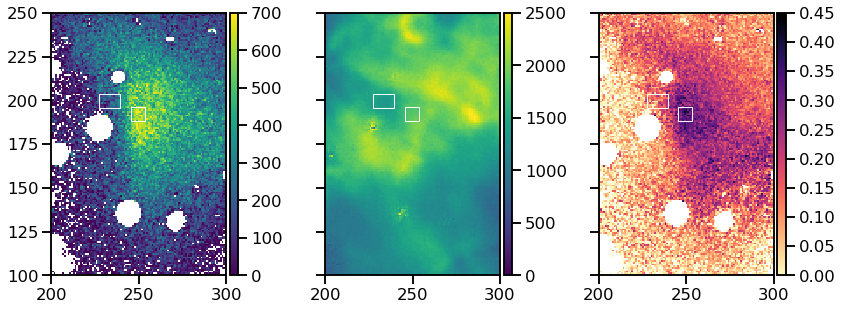

In [604]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
imariv.plot(ax=axes[0], vmin=0, vmax=700, colorbar="v")
imariii.plot(ax=axes[1], vmin=0, vmax=2500, colorbar="v")
(imariv / imariii).plot(ax=axes[2], vmin=0, vmax=0.45, cmap="magma_r", colorbar="v")
for ax in axes:
    bsbox.plot(ax=ax, color="w")
    bgbox.plot(ax=ax, color="w")
    ax.set(
        xlim=[200, 300],
        ylim=[100, 250],
    )
fig.tight_layout();    

In [613]:
bs_ariv = imariv[bsbox.slices].data.mean()
bg_ariv = imariv[bgbox.slices].data.mean()
sbs_ariv = imariv[bsbox.slices].data.std()
sbg_ariv = imariv[bgbox.slices].data.std()

bs_ariii = imariii[bsbox.slices].data.mean()
bg_ariii = imariii[bgbox.slices].data.mean()
sbs_ariii = imariii[bsbox.slices].data.std()
sbg_ariii = imariii[bgbox.slices].data.std()

In [614]:
f"[Ar IV]: BS = {bs_ariv:.2f} +/- {sbs_ariv:.2f}, BG = {bg_ariv:.2f} +/- {sbg_ariv:.2f}"

'[Ar IV]: BS = 599.60 +/- 74.58, BG = 199.84 +/- 91.40'

In [615]:
f"[Ar III]: BS = {bs_ariii:.2f} +/- {sbs_ariii:.2f}, BG = {bg_ariii:.2f} +/- {sbg_ariii:.2f}"

'[Ar III]: BS = 1832.30 +/- 45.06, BG = 1393.94 +/- 39.97'

In [617]:
BS_ariv = bs_ariv - bg_ariv
sBS_ariv = np.hypot(sbs_ariv, sbg_ariv)

BS_ariii = bs_ariii - bg_ariii
sBS_ariii = np.hypot(sbs_ariii, sbg_ariii)

BS_ar_iv_iii = BS_ariv / BS_ariii
sBS_ar_iv_iii = BS_ar_iv_iii * np.hypot(sBS_ariii / BS_ariii, sBS_ariv / BS_ariv)

f"BG-subtracted BS: [Ar IV] / [Ar III] = {BS_ar_iv_iii:.3f} +/- {sBS_ar_iv_iii:.3f}"

'BG-subtracted BS: [Ar IV] / [Ar III] = 0.912 +/- 0.297'

In [618]:
ar4 = pn.Atom("Ar", 4)
ar3 = pn.Atom("Ar", 3)

In [619]:
Ts = [15000, 17500, 20000]
e4711 = ar4.getEmissivity(tem=Ts, den=10.0, wave=4711)
e4740 = ar4.getEmissivity(tem=Ts, den=10.0, wave=4740)
e7136 = ar3.getEmissivity(tem=Ts, den=10.0, wave=7136)

In [620]:
e4711 + e4740

array([1.99637452e-20, 2.52768204e-20, 2.99956854e-20])

In [621]:
e7136

array([2.39725115e-20, 2.69514984e-20, 2.93572600e-20])

So the emissivity is very similar, strangely. 

Anyway, we should have:
$$
\frac {n(\mathrm{Ar^{3+}})} {n(\mathrm{Ar^{2+}})}
= 
\frac{I(4711 + 4740)}{I(7136)} 
\, \frac{e(7136)}{e(4711 + 4740)}
$$

In [622]:
e7136 / (e4711 + e4740)

array([1.20080232, 1.06625351, 0.97871609])

So the T uncertainty of +/- 2500 K would give +/- 10% uncertainty in the emissivity ratio. For the time being we take the middle value: 

In [623]:
Ar3p_over_Ar2p = BS_ar_iv_iii * (e7136 / (e4711 + e4740))[1]
Ar3p_over_Ar2p

0.9723735865565862

Or, close enough to unity.  So, at the inner edge of the bow shock we have 50% Ar++ and 50% Ar+++. We can use this to constrain the stellar spectrum if we run some Cloudy models.

## Can we get a He I density?

In [477]:
dgrid = [1.0, 10.0, 100.0, 1000.0]
T0 = [11000, 13000, 18000]
he1.getEmissivity(tem=T0, den=dgrid, wave=5876) / he1.getEmissivity(tem=T0, den=dgrid, wave=6678)

array([[3.52143762, 3.52143762, 3.52273521, 3.53264503],
       [3.5302056 , 3.5302056 , 3.5297992 , 3.53419086],
       [3.548379  , 3.548379  , 3.53549315, 3.49462034]])

## [Cl III] density

In [155]:
im5518 = Image("../data/ngc346-cliii-5518-bin01-sum.fits")
im5538 = Image("../data/ngc346-cliii-5538-bin01-sum.fits")
imha = Image("../data/ngc346-hi-6563-bin01-sum.fits")
imcont = Image("../data/ngc346-cont-4686-mean.fits")

In [156]:
cl3 = pn.Atom("Cl", 3)
Rlo = cl3.getLowDensRatio(wave1=5518, wave2=5538)
Rhi = cl3.getHighDensRatio(wave1=5518, wave2=5538)
Rlo, Rhi

(1.5, 0.213477825334669)

In [157]:
m = imcont.data > 3e2
im5518.mask = im5518.mask | m
im5538.mask = im5538.mask | m
trim_edges(im5518, 20)
trim_edges(im5538, 20)
trim_edges(imcont, 20)

In [158]:
shift5538 = 15.0 
shift5518 = 23.0
im5538.data += shift5538
im5518.data += shift5518

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


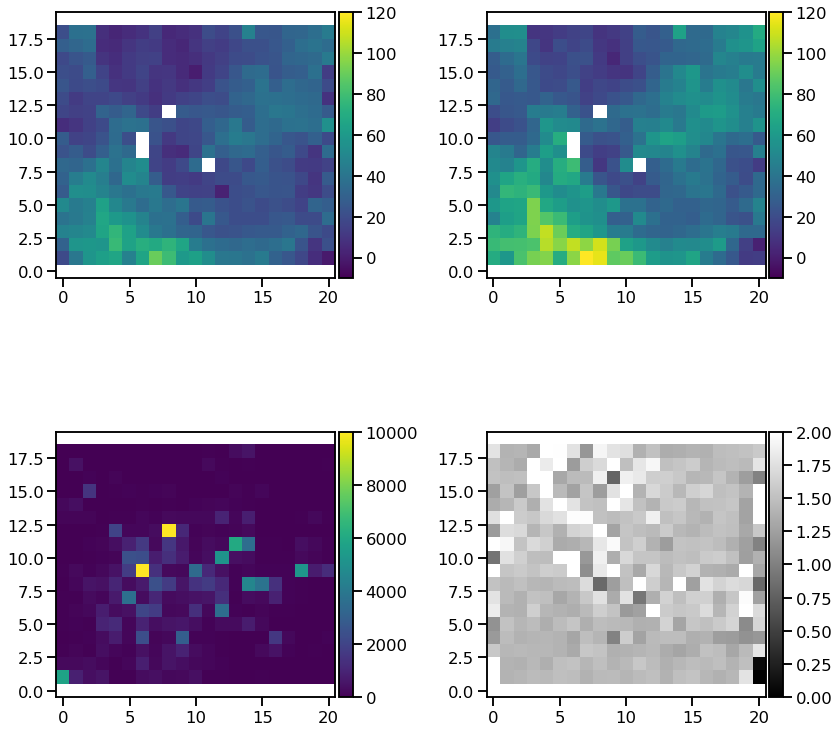

In [168]:
n = 16
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im5538.rebin(n).plot(vmin=-10, vmax=120, ax=axes[0, 0], colorbar="v")
im5518.rebin(n).plot(vmin=-10, vmax=120, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(
    im5518.rebin(n)
    / im5538.rebin(n)
).plot(
    ax=axes[1, 1],
    vmin=0.0, 
    vmax=2.0, 
    cmap="gray", 
    colorbar="v",
)
fig.tight_layout();

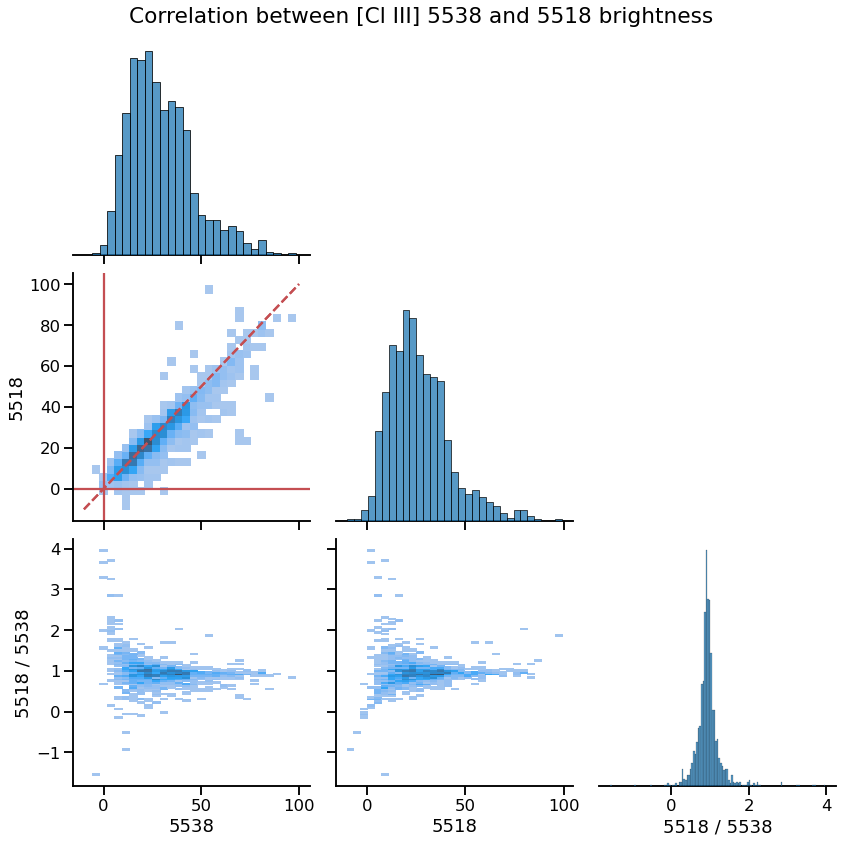

In [160]:
n = 8

imx = im5538.rebin(n)
imy = (im5518 /Rlo).rebin(n)

imin, imax = -10, 100
m = (imx.data < imax) & (imy.data < imax)
m = m & (imx.data > imin) & (imy.data > imin)
m = m & (imy.data / imx.data > -2) & (imy.data / imx.data  < 4.0)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "5538": imx.data[m],
        "5518": imy.data[m],
        "5518 / 5538": imy.data[m] / imx.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.fig.suptitle("Correlation between [Cl III] 5538 and 5518 brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


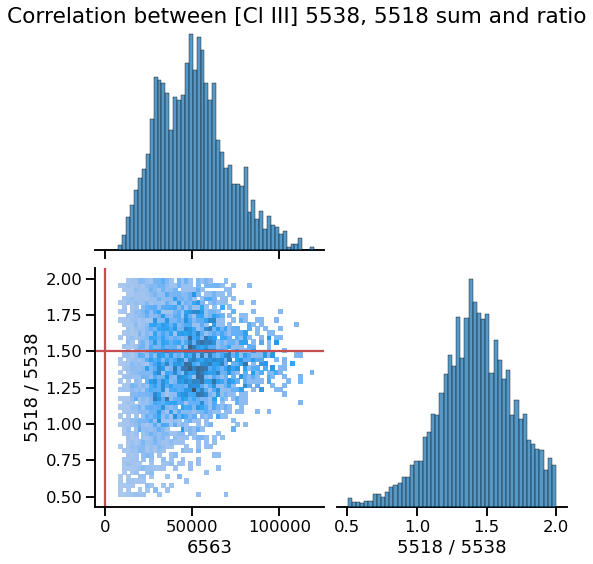

In [166]:
n = 4

imx = imha.rebin(n)
imy = im5518.rebin(n) / im5538.rebin(n)

imin, imax = -10, 100
m = (imy.data > 0.5) & (imy.data < 2.0)
m = m & (imx.data < 1.5e5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": imx.data[m],
        "5518 / 5538": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=50,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=50,
    ),
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(1.5, color="r")
g.fig.suptitle("Correlation between [Cl III] 5538, 5518 sum and ratio");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


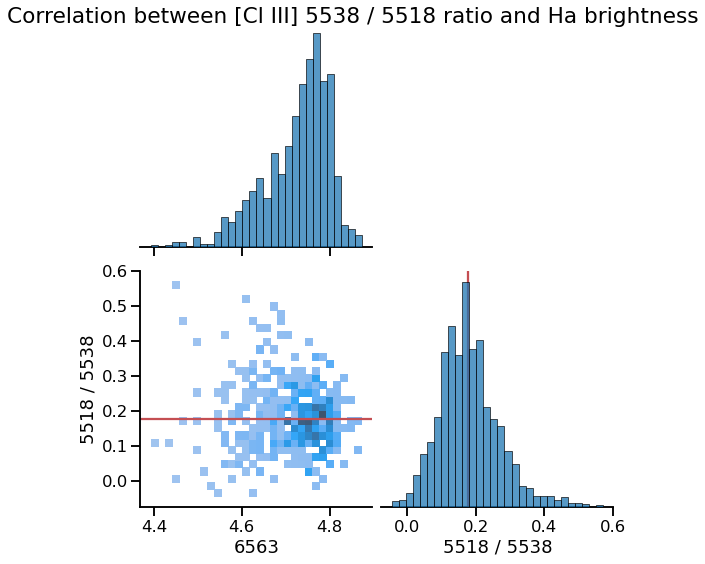

In [187]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 4

imx = imha[yslice, xslice].rebin(n)
imy = im5518[yslice, xslice].rebin(n) / im5538[yslice, xslice].rebin(n)

imin, imax = -10, 100
m = (imy.data > 0.15) & (imy.data < 15.0)
m = m & (imx.data < 1.5e5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "5518 / 5538": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=30,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=30,
    ),
)
g.axes[1, 0].axhline(np.log10(1.5), color="r")
g.axes[1, 1].axvline(np.log10(1.5), color="r")


g.fig.suptitle("Correlation between [Cl III] 5538 / 5518 ratio and Ha brightness");

In [211]:
m = ~im5518[yslice, xslice].mask
npix = m.sum()
y = im5518[yslice, xslice].data[m]
x = im5538[yslice, xslice].data[m]
w = imha[yslice, xslice].data[m]

# unweighted
ym = y.mean()
xm = x.mean()
R1 = ym / xm
dR1 = np.sqrt((y.var() / ym**2 + x.var() / xm**2) / (npix - 1))

# weighted 
ymw = np.average(y, weights=w)
xmw = np.average(x, weights=w)
R2 =  ymw / xmw
dR2 = np.sqrt(
    (
        np.average(((y - ymw) / ymw)**2, weights=w) 
        + np.average(((x - ymw) / xmw)**2, weights=w)
    ) / (npix - 1)
)
f"Unweighted R = {R1:.4f} +/- {dR1:.4f}; Weighted R = {R2:.4f} +/- {dR2:.4f}"

'Unweighted R = 1.4959 +/- 0.0090; Weighted R = 1.4924 +/- 0.0106'

In [219]:
cl3.getTemDen(1.44, tem=12000, wave1=5518, wave2=5538)

12.689610031679221

In [221]:
e5518 = cl3.getEmissivity(tem=12000, den=[1, 10, 100, 1000], wave=5518)
e5538 = cl3.getEmissivity(tem=12000, den=[1, 10, 100, 1000], wave=5538)
e5518 / e5538

array([1.44396914, 1.44119942, 1.41416716, 1.19711876])